<a href="https://colab.research.google.com/github/yongtaoliu/Ferroelectric-wall-dynamics-and-pinning-mechanisms/blob/main/Ferroelectric_DW_dynamics_Notebook1A_DCNN_for_Domain_Wall_Finding_GroupHED_TrainDataEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCNN for Domain Walls Finding**

May, 2021


*   Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
*   Workflow by Tommy Wong and modified by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
*   Training realized by [AtomAi](https://atomai.readthedocs.io/en/latest/) by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
*   Interferometric Displacement Sensor (IDS) PFM data on PZT by [Roger Proskch](https://scholar.google.com/citations?user=8OjHap0AAAAJ&hl=en)






**Package Version**


*   AtomAi: 0.5.2
*   Numpy: 1.19.5
*   Matplotlib: 3.2.2
*   Torch: 1.8.1+cu101
*   Scipy: 1.4.1





# **Install, Import, and Download**


*   Install and import required packages
*   Download train, test, and target PFM data set



In [ ]:
#@title Install Atomai
!pip install atomai==0.5.2

     |████████████████████████████████| 81kB 6.1MB/s 


In [ ]:
#@title Import Package
import numpy as np
import matplotlib.pyplot as plt
import cv2
from atomai.utils import extract_patches_ 
import atomai as aoi

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.ndimage import gaussian_filter

In [ ]:
#@title Download Data
!gdown -q https://drive.google.com/uc?id=1kRP5wK9cmPyI-i6BDEE-tBgpMfTFKQv8
!gdown -q https://drive.google.com/uc?id=1FX0K4akkJ6O9nfu8hmDg1sbZOZ2y2hXX
!gdown -q https://drive.google.com/uc?id=1DpCncyD95ibOARqpETxAvfYeyFdy-BVS
!gdown -q https://drive.google.com/uc?id=1j8fHO4a9U_O2JcYsXYZgcAX19hKOQpFY
!gdown -q https://drive.google.com/uc?id=1u0ybdFMpkdQk4JjVcOwPgDkvHYkWIchM
!gdown -q https://drive.google.com/uc?id=1YZ1qkOSPxyonwGJ17nL7vhSLXZLhY1Kz
!gdown -q https://drive.google.com/uc?id=1CkWYKumjpzDX0s6B9yiRueu1PeMumVa7
!gdown -q https://drive.google.com/uc?id=1PnuKsTlLTPFcSSn9trovq4Dr61rBYcAV
!gdown -q https://drive.google.com/uc?id=1-85A8hO6s8TkeEE0ohzmhJW4w60k-yo2
!gdown -q https://drive.google.com/uc?id=1jtWQv-rObUNpgTv8JV-meFvO89WGWyjY
!gdown -q https://drive.google.com/uc?id=1-8xfepSg1urL9XkfpfQuXDPowh7X9ePe
!gdown -q https://drive.google.com/uc?id=10gUuAg26e9u5lwp3hatr9h4y92Khsh_x
!gdown -q https://drive.google.com/uc?id=1-AGhQs5IdofLzcmn9QiTmFHbssba9qzV
!gdown -q https://drive.google.com/uc?id=1B56QSfUc2PVbOAls6n4W_BPzEE1hSq6p
!gdown -q https://drive.google.com/uc?id=1HGI6qZAqmYeeNZTewJot1q_AH06-ppkt

## **Define a function to extract sub_ images and _labeled walls as training data**

In [ ]:
#@title Define function: extract_subimage
def extract_subimage (x_train, y_train, numpatch = 400, patch_size= 400):
  #set patch number and patch size
  numpatches = numpatch
  patchsize = patch_size

  #read and normalize x_train
  img = plt.imread(x_train)[:,:,1]
  img = (img - img.min()) / img.ptp()

  #read and normalize y_train
  lab = plt.imread(y_train)
  lab = (lab - lab.min()) / lab.ptp()
  _, lab = cv2.threshold(lab, 0.9, 1, cv2.THRESH_BINARY)

  #generate training batch
  imgs, labs = extract_patches_(img, lab, patch_size=patchsize, num_patches=numpatches, random_state=42)

  #return subimage and label sets
  return imgs, labs

## **Define and train the model**


*  Define a model based on [holistically-nested edge detector](https://arxiv.org/pdf/1504.06375.pdf):
*  A residue network with Y-net structure was defined and trained
*  In the model, the input channels can be splited into n parts and each part was feed to equivalent conv layers, then each conv layer produces 1/n output channels and all output channels are subsequently concatenated. 


In [ ]:
#@title Run this cell to define a model with group
class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0.001,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0, groups = 1 )                
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1, groups = 2)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1, groups = 4)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward pass"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks with residual connections together
    """
    def __init__(self, input_channels, output_channels, res_depth,
                 lrelu_a=0.1, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels,
                         lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward pass"""
        x = self.res_module(x)
        return x

class hednet(nn.Module):
    def __init__(self):
        super(hednet, self).__init__()
        self.net1 = ResModule(1, 100, 4, use_batchnorm=True)
        self.net2 = nn.Sequential(
			nn.MaxPool2d(2, 2),
			ResModule(100, 200, 5, use_batchnorm=True)
		)
        self.net3 = nn.Sequential(
			nn.MaxPool2d(2, 2),
			ResModule(200, 400, 6, use_batchnorm=True)
		)
        self.net1score = nn.Sequential(
            nn.Conv2d(100, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.net2score = nn.Sequential(nn.Conv2d(
            200, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.net3score = nn.Sequential(nn.Conv2d(
            400, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.out = torch.nn.Conv2d(3, 1, 1, 1, 0)
    
    def forward(self, x):
        h, w = x.shape[2:4]
        net1out = self.net1(x)
        net2out = self.net2(net1out)
        net3out = self.net3(net2out)

        score1 = self.net1score(net1out)
        score2 = self.net2score(net2out)
        score3 = self.net3score(net3out)

        score2 = F.interpolate(score2, size=(h, w), mode='bilinear')
        score3 = F.interpolate(score3, size=(h, w), mode='bilinear')

        return self.out(torch.cat([score1, score2, score3], 1))

Train with dataset1


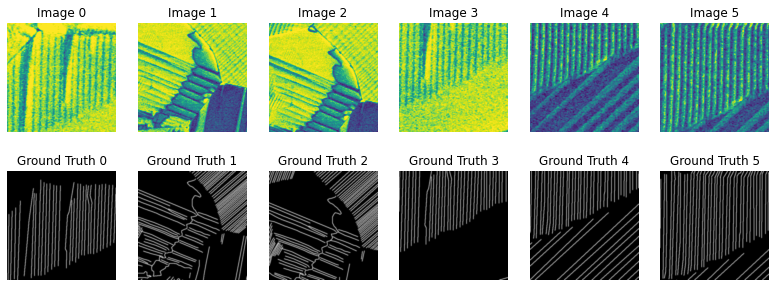

In [ ]:
#prepare dataset1

#xtrain and ytrain dataset according to download data
xtrain_load = ['MovieForGob_3.tiff', 'MovieForGob_30.tiff', 'MovieForGob_60.tiff', 'MovieForGob_100.tiff', 
          'Movie_HH_1.tiff', 'Movie_HH_15.tiff', 'Movie_HH_35.tiff']
ytrain_load = ['MovieForGob_3_label.tif', 'MovieForGob_30_label.tif', 'MovieForGob_60_label.tif', 'MovieForGob_100_label.tif', 
          'Movie_HH_1_Labels.tif', 'Movie_HH_15_Labels.tif', 'Movie_HH_35_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=200, patch_size=400)                           #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]


# show training images
n = 5

n = n + 2
fig = plt.figure(figsize=(16, 5))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_train[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

Mounted at /content/drive
Epoch 1 ... Training loss: 0.1045 ... Test loss: 0.0993 ... Train IoU: 0.2263 ... Test IoU: 0.0632 ... GPU memory usage: 15919/16280
Epoch 100 ... Training loss: 0.0649 ... Test loss: 0.0639 ... Train IoU: 0.5241 ... Test IoU: 0.4972 ... GPU memory usage: 15919/16280
Epoch 200 ... Training loss: 0.042 ... Test loss: 0.0338 ... Train IoU: 0.581 ... Test IoU: 0.6337 ... GPU memory usage: 15919/16280
Epoch 300 ... Training loss: 0.0305 ... Test loss: 0.024 ... Train IoU: 0.5577 ... Test IoU: 0.6372 ... GPU memory usage: 15919/16280
Epoch 400 ... Training loss: 0.0157 ... Test loss: 0.0223 ... Train IoU: 0.6817 ... Test IoU: 0.6133 ... GPU memory usage: 15919/16280
Epoch 500 ... Training loss: 0.0105 ... Test loss: 0.0124 ... Train IoU: 0.6913 ... Test IoU: 0.6692 ... GPU memory usage: 15919/16280
Epoch 600 ... Training loss: 0.01 ... Test loss: 0.0072 ... Train IoU: 0.6596 ... Test IoU: 0.7123 ... GPU memory usage: 15919/16280
Epoch 700 ... Training loss: 0.0061 

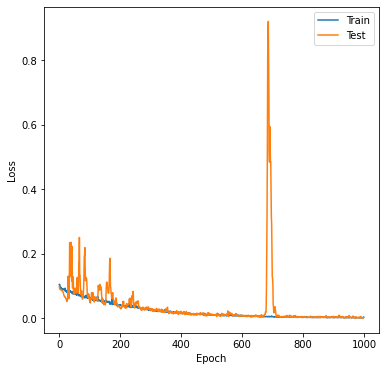

In [ ]:
#train with dataset1
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=1000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)      

trained_model = t.run()

Train with dataset2

In [ ]:
#prepare dataset2

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff', 'Movie_HH_15.tiff', 'Movie_HH_35.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif', 'Movie_HH_15_Labels.tif', 'Movie_HH_35_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=400)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0523 ... Test loss: 0.0473 ... Train IoU: 0.4421 ... Test IoU: 0.4584 ... GPU memory usage: 16001/16280
Epoch 100 ... Training loss: 0.0297 ... Test loss: 0.0314 ... Train IoU: 0.639 ... Test IoU: 0.5868 ... GPU memory usage: 16001/16280
Epoch 200 ... Training loss: 0.0187 ... Test loss: 0.0211 ... Train IoU: 0.6721 ... Test IoU: 0.6511 ... GPU memory usage: 16001/16280
Epoch 300 ... Training loss: 0.0118 ... Test loss: 0.016 ... Train IoU: 0.718 ... Test IoU: 0.6748 ... GPU memory usage: 16001/16280
Epoch 400 ... Training loss: 0.0066 ... Test loss: 0.0082 ... Train IoU: 0.765 ... Test IoU: 0.7414 ... GPU memory usage: 16001/16280
Epoch 500 ... Training loss: 0.0043 ... Test loss: 0.0069 ... Train IoU: 0.7972 ... Test IoU: 0.7558 ... GPU memory usage: 16001/16280
Epoch 600 ... Training loss: 0.0027 ... Test loss: 0.0032 ... Train

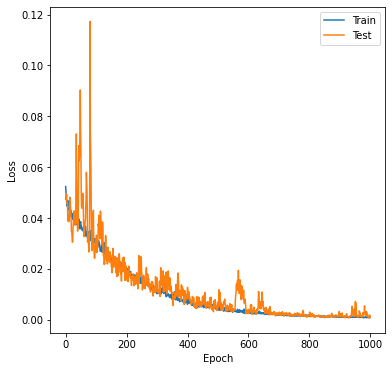

In [ ]:
#train with dataset2
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=1000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

train with dataset 3

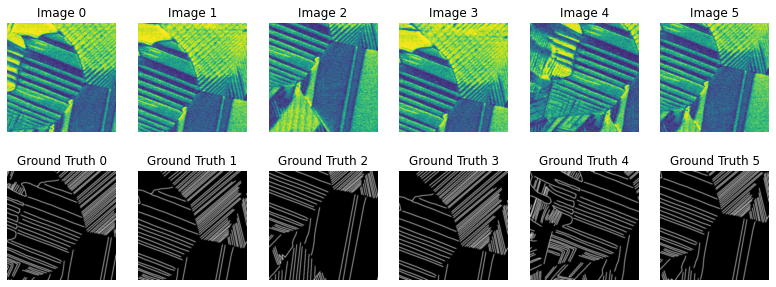

In [ ]:
#dataset3

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0532 ... Test loss: 0.0522 ... Train IoU: 0.4366 ... Test IoU: 0.4334 ... GPU memory usage: 16013/16280
Epoch 100 ... Training loss: 0.0266 ... Test loss: 0.027 ... Train IoU: 0.7115 ... Test IoU: 0.439 ... GPU memory usage: 16015/16280
Epoch 200 ... Training loss: 0.0152 ... Test loss: 0.0161 ... Train IoU: 0.7684 ... Test IoU: 0.7579 ... GPU memory usage: 16015/16280
Epoch 300 ... Training loss: 0.0084 ... Test loss: 0.0082 ... Train IoU: 0.8286 ... Test IoU: 0.8284 ... GPU memory usage: 16015/16280
Epoch 400 ... Training loss: 0.005 ... Test loss: 0.0054 ... Train IoU: 0.8626 ... Test IoU: 0.8566 ... GPU memory usage: 16015/16280
Epoch 500 ... Training loss: 0.0036 ... Test loss: 0.0031 ... Train IoU: 0.8825 ... Test IoU: 0.8824 ... GPU memory usage: 16015/16280
Epoch 600 ... Training loss: 0.0026 ... Test loss: 0.0021 ... Trai

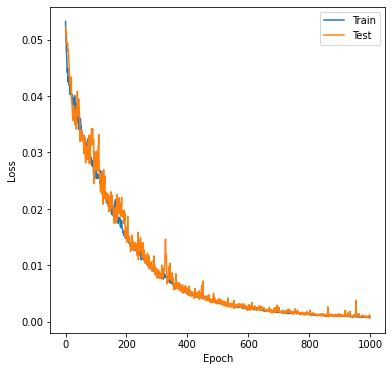

In [ ]:
#train with dataset3
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=1000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

Train with dataset4

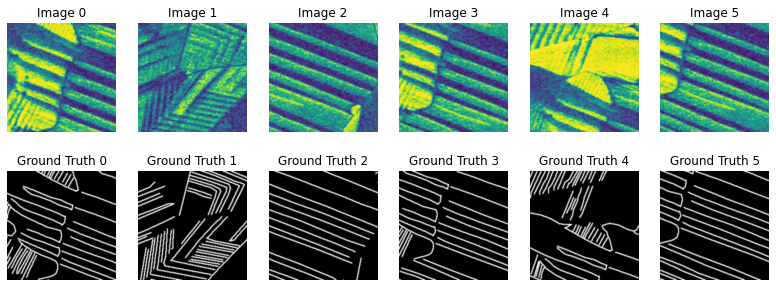

In [ ]:
#dataset4

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,200,200])
ytrain = np.empty([0,200,200])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size = 200)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0564 ... Test loss: 0.0528 ... Train IoU: 0.4237 ... Test IoU: 0.4295 ... GPU memory usage: 5113/16280
Epoch 100 ... Training loss: 0.0371 ... Test loss: 0.0327 ... Train IoU: 0.5806 ... Test IoU: 0.5861 ... GPU memory usage: 5113/16280
Epoch 200 ... Training loss: 0.0226 ... Test loss: 0.0138 ... Train IoU: 0.6406 ... Test IoU: 0.7253 ... GPU memory usage: 5113/16280
Epoch 300 ... Training loss: 0.0116 ... Test loss: 0.0169 ... Train IoU: 0.717 ... Test IoU: 0.7083 ... GPU memory usage: 5113/16280
Epoch 400 ... Training loss: 0.0096 ... Test loss: 0.0123 ... Train IoU: 0.7041 ... Test IoU: 0.6636 ... GPU memory usage: 5113/16280
Epoch 500 ... Training loss: 0.0071 ... Test loss: 0.0067 ... Train IoU: 0.7406 ... Test IoU: 0.7608 ... GPU memory usage: 5113/16280
Epoch 600 ... Training loss: 0.0052 ... Test loss: 0.0059 ... Train Io

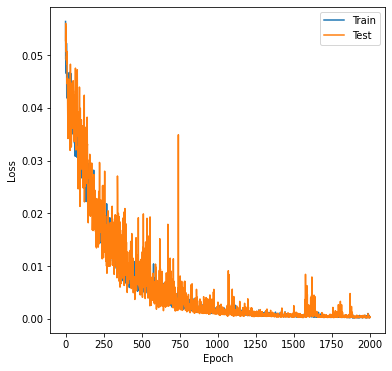

In [ ]:
#train with dataset4
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=2000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

Train with dataset5

In [ ]:
#dataset5

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,100,100])
ytrain = np.empty([0,100,100])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size = 100)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0527 ... Test loss: 0.0496 ... Train IoU: 0.4494 ... Test IoU: 0.4469 ... GPU memory usage: 2151/16280
Epoch 100 ... Training loss: 0.0363 ... Test loss: 0.0732 ... Train IoU: 0.5472 ... Test IoU: 0.4383 ... GPU memory usage: 2243/16280
Epoch 200 ... Training loss: 0.0231 ... Test loss: 0.0327 ... Train IoU: 0.6339 ... Test IoU: 0.5763 ... GPU memory usage: 2243/16280
Epoch 300 ... Training loss: 0.0222 ... Test loss: 0.0221 ... Train IoU: 0.602 ... Test IoU: 0.6113 ... GPU memory usage: 2243/16280
Epoch 400 ... Training loss: 0.0136 ... Test loss: 0.0094 ... Train IoU: 0.6777 ... Test IoU: 0.5828 ... GPU memory usage: 2243/16280
Epoch 500 ... Training loss: 0.0141 ... Test loss: 0.0089 ... Train IoU: 0.5992 ... Test IoU: 0.6915 ... GPU memory usage: 2243/16280
Epoch 600 ... Training loss: 0.011 ... Test loss: 0.0155 ... Train IoU

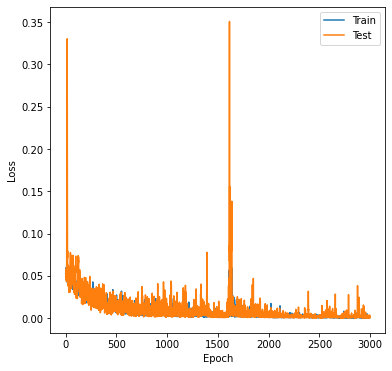

In [ ]:
#train with dataset5
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=3000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

Train with dataset6

In [ ]:
#dataset6

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,50,50])
ytrain = np.empty([0,50,50])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=1200, patch_size = 50)                       #change numpatch to maintain the total training dataset around ~1000-1500
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0586 ... Test loss: 0.0541 ... Train IoU: 0.3991 ... Test IoU: 0.4225 ... GPU memory usage: 1431/16280
Epoch 100 ... Training loss: 0.048 ... Test loss: 0.0584 ... Train IoU: 0.4688 ... Test IoU: 0.4523 ... GPU memory usage: 1517/16280
Epoch 200 ... Training loss: 0.0308 ... Test loss: 0.0217 ... Train IoU: 0.5725 ... Test IoU: 0.5563 ... GPU memory usage: 1517/16280
Epoch 300 ... Training loss: 0.031 ... Test loss: 0.0276 ... Train IoU: 0.5042 ... Test IoU: 0.5356 ... GPU memory usage: 1517/16280
Epoch 400 ... Training loss: 0.0166 ... Test loss: 0.038 ... Train IoU: 0.5886 ... Test IoU: 0.5235 ... GPU memory usage: 1517/16280
Epoch 500 ... Training loss: 0.0165 ... Test loss: 0.0263 ... Train IoU: 0.5683 ... Test IoU: 0.4872 ... GPU memory usage: 1517/16280
Epoch 600 ... Training loss: 0.0242 ... Test loss: 0.0143 ... Train IoU:

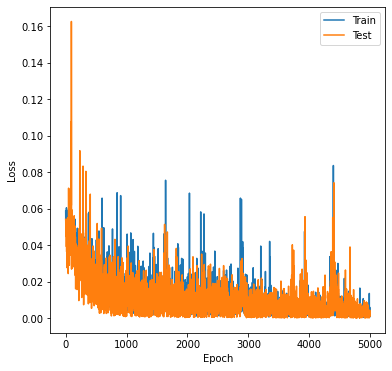

In [ ]:
#train with dataset6
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=5000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)

trained_model = t.run()

Train with dataset7

In [ ]:
#dataset7

#xtrain and ytrain dataset according to download data
xtrain_load = ['Movie_HH_1.tiff']
ytrain_load = ['Movie_HH_1_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,50,50])
ytrain = np.empty([0,50,50])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j, numpatch=3600, patch_size = 50)                       #triple numpatch 
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

#Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 ... Training loss: 0.0558 ... Test loss: 0.0481 ... Train IoU: 0.4231 ... Test IoU: 0.4541 ... GPU memory usage: 1421/16280
Epoch 100 ... Training loss: 0.0441 ... Test loss: 0.0736 ... Train IoU: 0.4791 ... Test IoU: 0.4265 ... GPU memory usage: 1513/16280
Epoch 200 ... Training loss: 0.0352 ... Test loss: 0.0315 ... Train IoU: 0.5151 ... Test IoU: 0.5366 ... GPU memory usage: 1513/16280
Epoch 300 ... Training loss: 0.0214 ... Test loss: 0.02 ... Train IoU: 0.597 ... Test IoU: 0.5957 ... GPU memory usage: 1513/16280
Epoch 400 ... Training loss: 0.0139 ... Test loss: 0.0264 ... Train IoU: 0.6337 ... Test IoU: 0.5769 ... GPU memory usage: 1513/16280
Epoch 500 ... Training loss: 0.018 ... Test loss: 0.0108 ... Train IoU: 0.5403 ... Test IoU: 0.5166 ... GPU memory usage: 1513/16280
Epoch 600 ... Training loss: 0.0267 ... Test loss: 0.0042 ... Train IoU: 

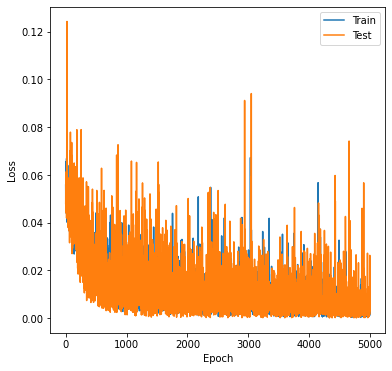

In [ ]:
#train with dataset7
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=5000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)
trained_model = t.run()

# **Test the model using labelled data**


*   Make predictions on the validation data sets 
*   A comparison of predictions with ground truth shows that predicted wall maps are well consistent with ground truth



In [ ]:
!gdown https://drive.google.com/uc?id=1JDqg3pEBtw5d_U13IRSZTmqeZwqwSIoi
!gdown https://drive.google.com/uc?id=1-icvRA-q9gq0TanapeQlCJgVVAWc1-bt
!gdown https://drive.google.com/uc?id=1-n0ybG2K90Bu5tqCALItTZNDosTMYshC
!gdown https://drive.google.com/uc?id=1WmmAjF3GotKh_Vcu9BDAWlirSgogIzuG
!gdown https://drive.google.com/uc?id=1-2YcVXNT7Ac23K6jijeDNFcEmPKHdPUW
!gdown https://drive.google.com/uc?id=1-3aNQO0O_Ywt3VfeGhJ_j99esi_UW4IY
!gdown https://drive.google.com/uc?id=13qJBpZ7270yMk6lQWoDKSgTbmKqrXyRI

Downloading...
From: https://drive.google.com/uc?id=1JDqg3pEBtw5d_U13IRSZTmqeZwqwSIoi
To: /content/drive/My Drive/DCNN_domain_walls/YL_edit/TrainingData/Ferroelectric_DW_dynamics_Notebook4-1_Dataset1_withgroup_metadict_final_weights.tar
37.0MB [00:00, 65.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-icvRA-q9gq0TanapeQlCJgVVAWc1-bt
To: /content/drive/My Drive/DCNN_domain_walls/YL_edit/TrainingData/Ferroelectric_DW_dynamics_Notebook4-1_Dataset2_withgroup_metadict_final_weights.tar
37.0MB [00:00, 118MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-n0ybG2K90Bu5tqCALItTZNDosTMYshC
To: /content/drive/My Drive/DCNN_domain_walls/YL_edit/TrainingData/Ferroelectric_DW_dynamics_Notebook4-1_Dataset3_withgroup_metadict_final_weights.tar
37.0MB [00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WmmAjF3GotKh_Vcu9BDAWlirSgogIzuG
To: /content/drive/My Drive/DCNN_domain_walls/YL_edit/TrainingData/Ferroelectric_DW_dynamics_Notebook4-1_Dataset4_withgroup_metad

Download and load test data

In [ ]:
!gdown https://drive.google.com/uc?id=1-ZtgJ7y6L9BKQtaQYmz3ePtvZszOn_vO

Downloading...
From: https://drive.google.com/uc?id=1-ZtgJ7y6L9BKQtaQYmz3ePtvZszOn_vO
To: /content/drive/My Drive/DCNN_domain_walls/YL_edit/TrainingData/hed_test_data.npz
308MB [00:01, 203MB/s]


In [ ]:
data_test = np.load('hed_test_data.npz')
xtest = data_test['imgs'][:, None, ...]; ytest = data_test['labs'][:, None, ...] 

Load ResHed weight

In [ ]:
trained_model = hednet()
weights = torch.load('Ferroelectric_DW_dynamics_Notebook4-1_Dataset7_withgroup_metadict_final_weights.tar')["weights"]  #load the weight you want to check
trained_model.load_state_dict(weights)
# trained_model.eval()

<All keys matched successfully>

Make precition on validation images and compare with ground truth

In [ ]:
p = aoi.atomnet.predictor(trained_model, use_gpu=True)
prediction, _ = p.run(xtest)

/usr/local/lib/python3.7/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 50/50
50 images were decoded in approximately 11.5313 seconds


Text(0.5, 1.0, 'GHED Prediction')

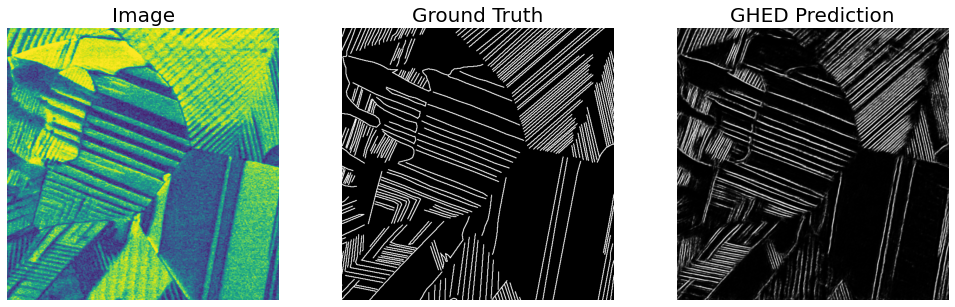

In [ ]:
k = 1
_,(ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(17, 5))
ax0.imshow(xtest[k, 0])
ax0.axis ('off')
ax0.set_title('Image', fontsize = 20)
ax1.imshow(ytest[k, 0], cmap = 'gray')
ax1.axis('off')
ax1.set_title('Ground Truth', fontsize = 20)
ax2.imshow(prediction[k,...,0], cmap = 'gray')
ax2.axis('off')
ax2.set_title('GHED Prediction', fontsize = 20)